In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [36]:
!pip install pymc aesara


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.4 MB/s eta 0:00:00a 0:00:01


In [48]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

df=pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')


def preprocess_data(df):
    df = df.copy()
    
    df['log_price'] = np.log(df['price'])
    df['engine_size'] = df['engine'].str.extract('(\d+\.\d+|\d+)').astype(float)
    df['is_hybrid_electric'] = df['fuel_type'].str.contains('Hybrid|Electric', case=False, na=False).astype(int)

    categorical_cols = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col].fillna('Unknown'))
    
    numerical_cols = ['model_year', 'milage', 'engine_size']
    df[numerical_cols] = RobustScaler().fit_transform(df[numerical_cols])
    
    df = df.drop(['engine','price'], axis=1)

    return df[:50000]

df = preprocess_data(df)

print(df.isna().sum())

df = df.dropna()

# Split the data
X = df.drop('log_price', axis=1)
y = df['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print some statistics about the target variable
print("Target variable statistics:")
print(y_train.describe())

id                      0
brand                   0
model                   0
model_year              0
milage                  0
fuel_type               0
transmission            0
ext_col                 0
int_col                 0
accident                0
clean_title             0
log_price               0
engine_size           483
is_hybrid_electric      0
dtype: int64
Target variable statistics:
count    39613.000000
mean        10.289843
std          0.851990
min          7.600902
25%          9.740910
50%         10.325482
75%         10.817776
max         14.898699
Name: log_price, dtype: float64


Output()

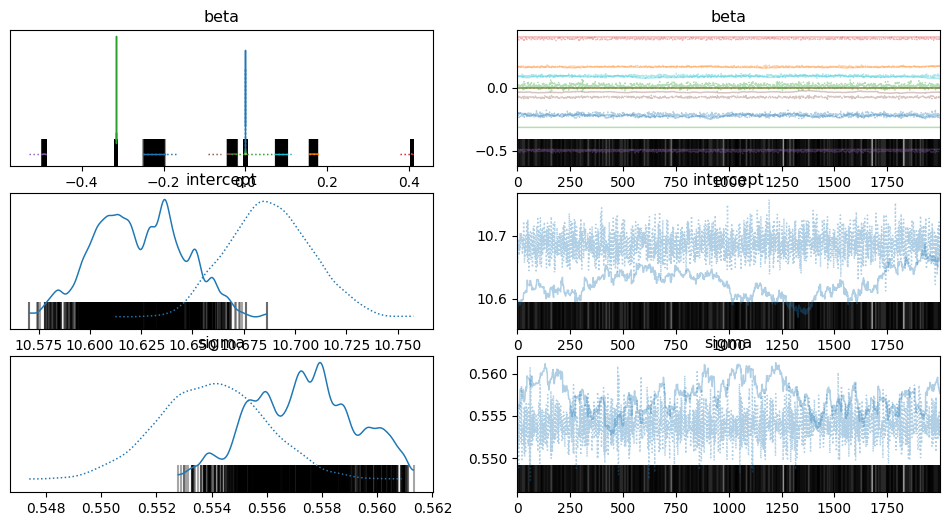

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]     0.000  0.000  -0.000    0.000      0.000    0.000      30.0   
beta[1]     0.001  0.000   0.001    0.002      0.000    0.000       3.0   
beta[2]    -0.000  0.000  -0.000   -0.000      0.000    0.000      35.0   
beta[3]     0.399  0.008   0.386    0.407      0.005    0.004       3.0   
beta[4]    -0.498  0.008  -0.511   -0.490      0.005    0.004       3.0   
beta[5]    -0.054  0.021  -0.083   -0.029      0.014    0.012       3.0   
beta[6]    -0.000  0.000  -0.001    0.000      0.000    0.000       3.0   
beta[7]    -0.000  0.000  -0.000   -0.000      0.000    0.000       5.0   
beta[8]     0.001  0.000   0.000    0.001      0.000    0.000       8.0   
beta[9]     0.093  0.007   0.079    0.105      0.002    0.002      10.0   
beta[10]   -0.219  0.011  -0.239   -0.198      0.003    0.002      19.0   
beta[11]    0.168  0.004   0.161    0.176      0.001    0.001       7.0   
beta[12]   -0.149  0.166 

In [49]:
# Create PyMC model
with pm.Model() as model:
    # Priors for unknown model parameters
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=X_train.shape[1])
    
    # Expected value of outcome
    mu = intercept + pm.math.dot(X_train, beta)
    
    # Likelihood (sampling distribution) of observations
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

# Perform inference
with model:
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Analyze results
az.plot_trace(trace)
plt.show()

summary = az.summary(trace)
print(summary)

In [45]:
# Function to predict prices
def predict_price(X, trace):
    intercept = trace.posterior['intercept'].mean(dim=['chain', 'draw']).values
    beta = trace.posterior['beta'].mean(dim=['chain', 'draw']).values
    return intercept + np.dot(X, beta)


# Predict prices for test set
test_predictions = predict_price(X_test, trace)

Mean Absolute Error: $0.39


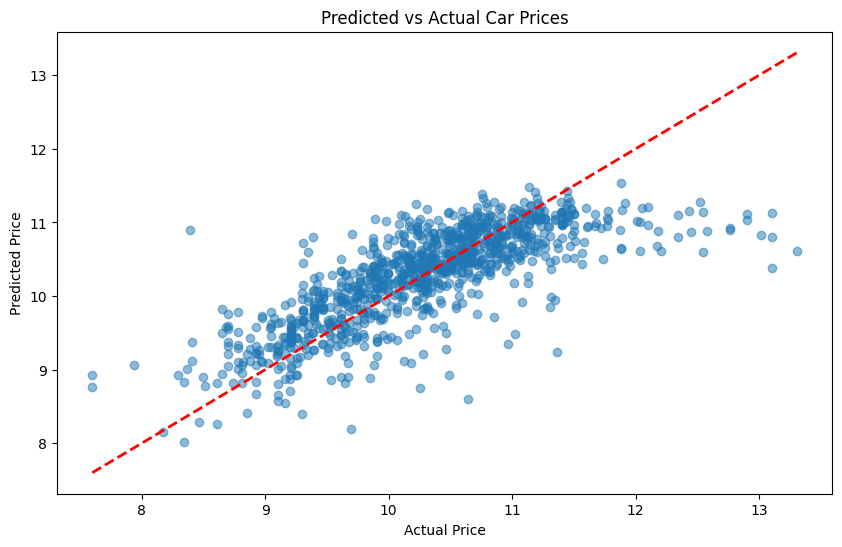

In [46]:
# Calculate Mean Absolute Error
mae = np.mean(np.abs(test_predictions - y_test))
print(f"Mean Absolute Error: ${mae:.2f}")

# Plot predicted vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Car Prices")
plt.show()

In [47]:
# Predict prices for test set
y_pred = predict_price(X_test.values, trace)

# Calculate RMSE
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print(f"RMSE: {rmse}")

# Print a few predictions alongside actual prices
print("\nSample predictions:")
for i in range(5):
    print(f"Actual: ${y_test.iloc[i]:.2f}, Predicted: ${y_pred[i]:.2f}")

RMSE: 0.5325476273208616

Sample predictions:
Actual: $11.09, Predicted: $10.58
Actual: $9.79, Predicted: $10.39
Actual: $9.39, Predicted: $10.25
Actual: $9.38, Predicted: $9.26
Actual: $9.85, Predicted: $9.71


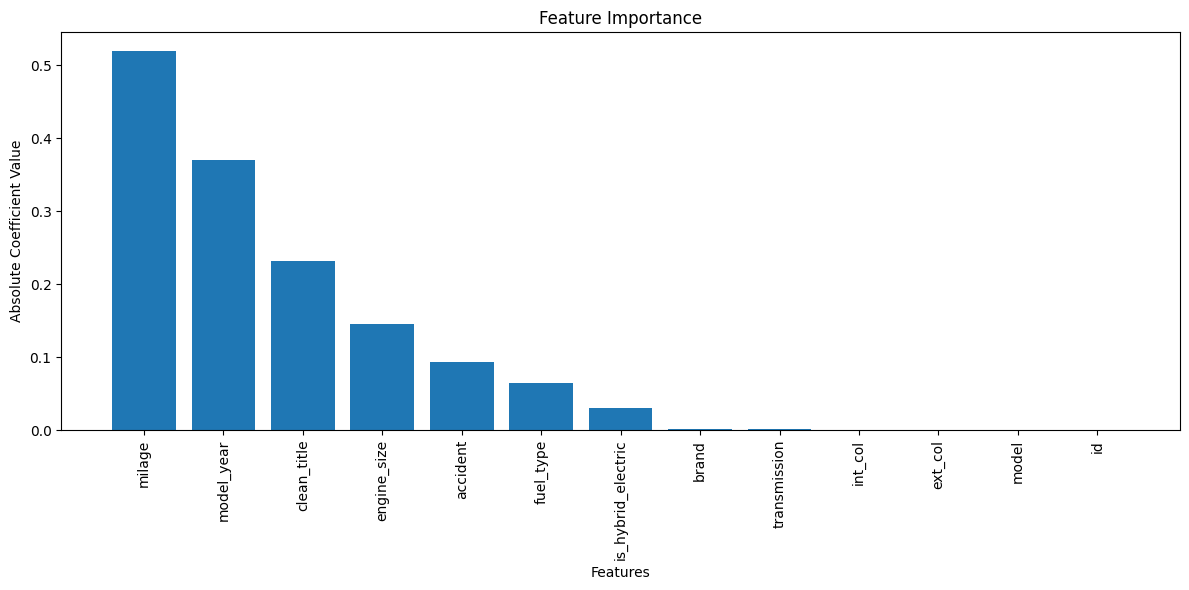

In [28]:
# Feature importance
feature_importance = {col: np.abs(trace.posterior['beta'].mean(dim=['chain', 'draw']).values)[idx] for idx, col in enumerate(X.columns)}
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(12, 6))
plt.bar([x[0] for x in sorted_features], [x[1] for x in sorted_features])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Absolute Coefficient Value")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [29]:
!pip install GPy GPyOpt

Best configuration:
id: 38257.135713534924
brand: 44.54982196507597
model: 1471.8934132026725
model_year: 0.7745686426020284
milage: -0.6854515629515062
fuel_type: 4.904112343297578
transmission: 38.650733195403326
ext_col: 0.6537433803843293
int_col: 79.40607892548853
accident: 1.8599741418150106
clean_title: 0.517377846594714
engine_size: 2.2290400615527504
is_hybrid_electric: 0.13494890609754762
Predicted price: $11.51


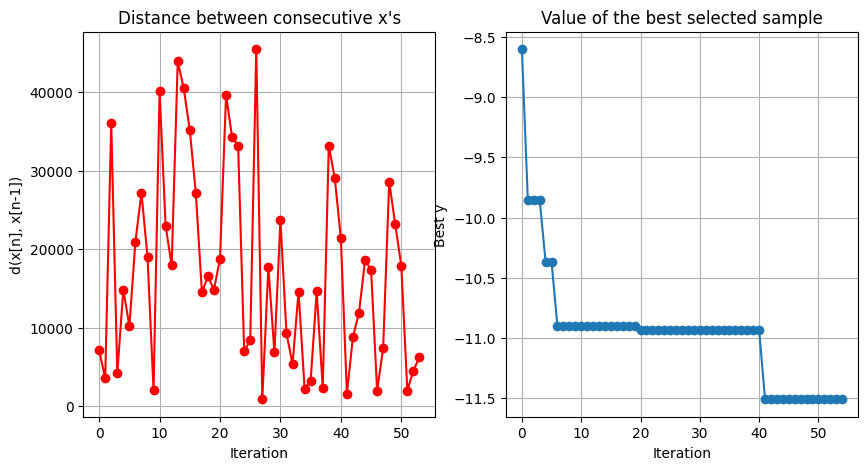

In [50]:
# Bayesian Optimization with Gaussian Process
import GPy
import GPyOpt

# Function to predict prices
def predict_price(X, trace):
    intercept = trace.posterior['intercept'].mean(dim=['chain', 'draw']).values
    beta = trace.posterior['beta'].mean(dim=['chain', 'draw']).values
    return intercept + np.dot(X, beta)

# Define the objective function (negative predicted price)
def objective_function(X):
    return -predict_price(X, trace)

# Define the domain
bounds = []
for col in X.columns:
    bounds.append({'name': col, 'type': 'continuous', 'domain': (X[col].min(), X[col].max())})

# Create the Bayesian optimization object
optimizer = GPyOpt.methods.BayesianOptimization(
    f=objective_function, 
    domain=bounds,
    model_type='GP',
    acquisition_type='EI',
    normalize_Y=True
)

# Run the optimization
optimizer.run_optimization(max_iter=50)

# Get the best solution
best_x = optimizer.x_opt
best_y = -optimizer.fx_opt

print("Best configuration:")
for i, col in enumerate(X.columns):
    print(f"{col}: {best_x[i]}")
print(f"Predicted price: ${best_y:.2f}")

# Plot the optimization results
optimizer.plot_acquisition()
plt.show()

optimizer.plot_convergence()
plt.show()

Submission

In [31]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

def preprocess_data_test(df):
    df = df.copy()
    
    # Extract numeric engine size or horsepower
    df['engine_size'] = df['engine'].str.extract('(\d+\.\d+|\d+)').astype(float)
    df['engine_size'].interpolate(method='linear', inplace=True)
    
    # Create a binary column for hybrid/electric vehicles
    df['is_hybrid_electric'] = df['fuel_type'].str.contains('Hybrid|Electric', case=False, na=False).astype(int)
    
    # Inpute Missing values
    df['fuel_type'].fillna(df['fuel_type'].mode()[0])
    
    # 2. Accident
    # For accident, we might assume that missing values indicate no accident
    df['accident'] = df['accident'].fillna('None reported')

    # 3. Clean Title
    # For clean title, we might use a similar approach as accident
    df['clean_title'] = df['clean_title'].fillna('Yes')
    
    # Example using Iterative Imputation (MICE)
#     numerical_columns = ['model_year', 'milage']  # Add any other numerical columns
#     categorical_columns = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

#     # One-hot encode categorical variables
#     df_encoded = pd.get_dummies(df, columns=categorical_columns)

#     # Create the IterativeImputer
#     iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=0)

#     # Fit and transform the data
#     df_imputed = pd.DataFrame(iterative_imputer.fit_transform(df_encoded), columns=df_encoded.columns)

    
    # Encode categorical variables
    categorical_cols = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col].fillna('Unknown'))
    
    # Scale numerical features
    numerical_cols = ['model_year', 'milage', 'engine_size']
    df[numerical_cols] = RobustScaler().fit_transform(df[numerical_cols])
    
    df = df.drop(['engine'], axis=1)

    return df

test_df = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
test_df = preprocess_data_test(test_df)
y_pred = pd.DataFrame({
    'id': test_df['id'],
    'price': np.exp(predict_price(test_df, trace))
})
y_pred.to_csv('submission.csv', index=False)
y_pred.isna().sum()

id       0
price    0
dtype: int64